In [1]:
!pip install tensorflow

Epoch 1/10
38/38 [==============================] - 12s 147ms/step - loss: 3.0200e-04 - val_loss: 1.0182e-05
Epoch 2/10
38/38 [==============================] - 5s 132ms/step - loss: 1.0184e-05 - val_loss: 5.9830e-06
Epoch 3/10
38/38 [==============================] - 5s 122ms/step - loss: 6.2235e-06 - val_loss: 5.1890e-06
Epoch 4/10
38/38 [==============================] - 4s 103ms/step - loss: 5.8445e-06 - val_loss: 4.9768e-06
Epoch 5/10
38/38 [==============================] - 4s 114ms/step - loss: 5.7917e-06 - val_loss: 4.8079e-06
Epoch 6/10
38/38 [==============================] - 5s 127ms/step - loss: 5.6629e-06 - val_loss: 4.7242e-06
Epoch 7/10
38/38 [==============================] - 4s 100ms/step - loss: 5.5197e-06 - val_loss: 4.8121e-06
Epoch 8/10
38/38 [==============================] - 4s 102ms/step - loss: 5.5364e-06 - val_loss: 4.7064e-06
Epoch 9/10
38/38 [==============================] - 6s 157ms/step - loss: 5.3695e-06 - val_loss: 4.5822e-06
Epoch 10/10
10/10 [========

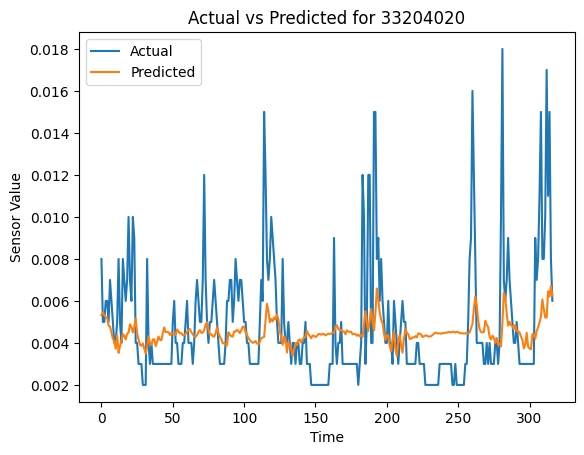

In [3]:
from threading import active_count
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataset=pd.read_csv('/content/so2_20180101_20231031 (1).csv')

#select the column 'V' for prediction
selected_column='33204020'

#split  the selected column into training and testing sets
train_data,test_data=train_test_split(dataset[selected_column],test_size=0.2,shuffle=False)

#Define the forecasting horizon
forecast_horizon=24

#Function to prepare input features and target variable
def prepare_data(data,forecast_horizon):
  X,y=[],[]
  for i in range(len(data)-forecast_horizon):
    X.append(data[i:(i+forecast_horizon)])
    y.append(data[i+forecast_horizon])
  return np.array(X),np.array(y)

#Prepare the training and testing data
X_train,y_train=prepare_data(train_data.values,forecast_horizon)
X_test,y_test=prepare_data(test_data.values,forecast_horizon)

#Reshape the data for the Transformer model input
#Reshape the data for the Transformer model input
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1)) # Remove X_train from the reshape arguments
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],1))   # Remove X_test from the reshape arguments

#Define the Transformer model input
def transformer_encoder(inputs,head_size,num_heads,ff_dim,dropout=0,name="transformer_encoder"):
  x=tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
  x=tf.keras.layers.MultiHeadAttention(
      key_dim=head_size,num_heads=num_heads,dropout=dropout
  )(x,x)
  x=tf.keras.layers.Dropout(dropout)(x)
  res=x+inputs

#Feed Forward Part
  x=tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
  x=tf.keras.layers.Conv1D(filters=ff_dim,kernel_size=1,activation="relu")(x) # Changed ConvID to Conv1D
  x=tf.keras.layers.Dropout(dropout)(x)
  x=tf.keras.layers.Conv1D(filters=inputs.shape[-1],kernel_size=1)(x)
  return x+res

#Define the Transformer model
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mpl_dropout=0):
  inputs=tf.keras.layers.Input(shape=input_shape)
  x=inputs
  for _ in range(num_transformer_blocks):
    x=transformer_encoder(x,head_size,num_heads,ff_dim,dropout)
  x=tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x) # Changed GlobalAveragePoolingID to GlobalAveragePooling1D
  for dim in mlp_units:
    x=tf.keras.layers.Dense(dim,activation="relu")(x)
    x=tf.keras.layers.Dropout(mpl_dropout)(x)
  outputs=tf.keras.layers.Dense(1,activation="linear")(x) # Added missing . after layers
  return tf.keras.Model(inputs,outputs)

#set hyperparameters
input_shape=X_train.shape[1:]
head_size=256
num_heads=4
ff_dim=256
num_transformer_blocks=2
mlp_units=[256]
dropout=0.2
mpl_dropout=0.4

#Build the model
model=build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout,mpl_dropout)

#compile the model
model.compile(optimizer='adam',loss='mse')

#Train the model with reduced epoches (10 epochs)
history=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.1)


#Make predictions on the test data
predictions=model.predict(X_test)

#Calculate RMSE
rmse=np.sqrt(mean_squared_error(y_test,predictions))
print(f"Root Mean Squared Error: {rmse}:",rmse)

#Visualize prediction vs actual values
plt.plot(y_test,label='Actual')
plt.plot(predictions,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.title('Actual vs Predicted for {}'.format(selected_column))
plt.legend()
plt.show()